In [1]:
import matplotlib.pyplot as plt
import fitz  # PyMuPDF
from transformers import pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import spacy

In [2]:
# Function to extract text from PDF
def extract_text_from_pdf(file_path):
    text_content = []
    with fitz.open(file_path) as pdf:
        for page_num in range(pdf.page_count):
            page_text = pdf[page_num].get_text()
            text_content.append(page_text)
    return "\n".join(text_content)

# Example usage
q1_text = extract_text_from_pdf('Barclays_6-K_for_Q1_2023.pdf')
q2_text = extract_text_from_pdf('Barclays_6-K_for_Q2_2023.pdf')
q3_text = extract_text_from_pdf('Barclays_6-K_for_Q3_2023.pdf')
bcls_annual_text = extract_text_from_pdf('Barclays_20-F_for_2023.pdf')
gs_annual_text = extract_text_from_pdf('Goldman_Sachs_10-K_for_2023.pdf')
hsbc_annual_text = extract_text_from_pdf('HSBC_10-K_form_for_2023.pdf')
jpm_annual_text = extract_text_from_pdf('JP_Morgan_10-K_2023.pdf')
san_annual_text = extract_text_from_pdf('Santander_10-K_for_2023.pdf')

In [3]:
# Load the summarization pipeline
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

# Example: Summarizing each report
summaries = {}
for report_name, text in {
    "Q1 Report": q1_text,
    "Q2 Report": q2_text,
    "Q3 Report": q3_text,
    "Barclays Annual Report": bcls_annual_text,
    "Goldman Sachs Annual Report": gs_annual_text,
    "HSBC Annual Report": hsbc_annual_text,
    "JP Morgan Annual Report": jpm_annual_text,
    "Santander Annual Report": san_annual_text,
}.items():
    # Summarize up to the first 2000 characters (can adjust based on memory limits)
    summary = summarizer(text[:2000], max_length=150, min_length=50, do_sample=False)
    summaries[report_name] = summary[0]['summary_text']
    print(f"{report_name} Summary:", summaries[report_name], "\n")


Q1 Report Summary: This Report on Form 6-K is filed by Barclays PLC. Indicate by check mark whether the registrant files or will file annual reports under cover of Form 20-F or Form 40-F. If "Yes" is marked, indicate below the file number assigned to the Registrant. 

Q2 Report Summary: Report of Foreign Private Issuer of Barclays PLC. Report comprises the following:. A table setting forth the issued share capital of Barclays. PLC and the Barclays P.LC Group’s total shareholders’ equity, indebtedness and contingent.liabilities as at 30 June 2023. The most recent reported statement of position, and updated for any significant or material items since that reporting date. 

Q3 Report Summary: This Report on Form 6-K is filed by Barclays PLC. The abbreviations '£m' and '£bn' represent millions and thousands of millions of Pounds Sterling respectively. Unless otherwise stated, the income statement analysis compares the nineophobicmonths ended 30 September 2023 to the corresponding nine mont

Your max_length is set to 150, but your input_length is only 137. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)


Goldman Sachs Annual Report Summary: Saudi Arabia is one of the wealthiest countries in the world. The country has the highest per capita GDP in the Middle East. It is also the wealthiest nation in Europe, with a GDP of more than $1.2 billion. 

HSBC Annual Report Summary: Saudi Arabia is one of the wealthiest countries in the world. The country has a population of more than 100 million people. It is also the largest economy in the Middle East. It has the highest per capita GDP of any country in the region. 



Your max_length is set to 150, but your input_length is only 129. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=64)


JP Morgan Annual Report Summary: Saudi Arabia is one of the wealthiest countries in the world. The country has a population of more than 1.5 billion people. It is also the largest economy in the Middle East, with more than twice the GDP than any other country. 

Santander Annual Report Summary: Saudi Arabia is one of the wealthiest countries in the world. The country has a population of more than 100 million people. It is also the largest economy in the Middle East. It has the highest per capita GDP of any country in the region. 



In [4]:
# Load sentiment analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis")

# Analyze sentiment for a specific section in each report
sentiments = {}
for report_name, text in summaries.items():  # Using summaries to reduce computation
    sentiment_result = sentiment_analyzer(text)
    sentiments[report_name] = sentiment_result
    print(f"{report_name} Sentiment Analysis:", sentiment_result, "\n")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Q1 Report Sentiment Analysis: [{'label': 'NEGATIVE', 'score': 0.998875081539154}] 

Q2 Report Sentiment Analysis: [{'label': 'NEGATIVE', 'score': 0.5461456775665283}] 

Q3 Report Sentiment Analysis: [{'label': 'NEGATIVE', 'score': 0.992966890335083}] 

Barclays Annual Report Sentiment Analysis: [{'label': 'NEGATIVE', 'score': 0.9911501407623291}] 

Goldman Sachs Annual Report Sentiment Analysis: [{'label': 'POSITIVE', 'score': 0.9990905523300171}] 

HSBC Annual Report Sentiment Analysis: [{'label': 'POSITIVE', 'score': 0.999309778213501}] 

JP Morgan Annual Report Sentiment Analysis: [{'label': 'POSITIVE', 'score': 0.9990701079368591}] 

Santander Annual Report Sentiment Analysis: [{'label': 'POSITIVE', 'score': 0.999309778213501}] 



In [5]:
# Combine summaries for a topic model analysis
combined_text = " ".join(summaries.values())
# Load spaCy's small English model
nlp = spacy.load("en_core_web_sm")

# Tokenize text using spaCy
doc = nlp(combined_text)
segments = [sent.text for sent in doc.sents]


In [6]:
# Vectorize text for topic modeling
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(segments)

# Apply LDA to extract topics
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Display topics
for index, topic in enumerate(lda.components_):
    print(f"Topic #{index + 1}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


Topic #1:
['gdp', 'country', 'shell', 'reported', 'company', 'arabia', 'saudi', 'countries', 'world', 'wealthiest']
Topic #2:
['ended', '2022', '31', 'annual', 'company', 'region', 'capita', 'highest', 'gdp', 'country']
Topic #3:
['country', 'form', 'million', '100', 'filed', 'people', 'population', 'report', 'plc', 'barclays']
Topic #4:
['september', 'months', 'annual', '31', 'reported', 'form', 'economy', 'largest', 'middle', 'east']
Topic #5:
['people', 'shell', 'ended', '2022', 'september', 'months', 'statement', '2023', '30', 'billion']


In [48]:
import requests

# Set your Azure OpenAI endpoint and API key
endpoint = "https://genai-openai-cognitivecollective.openai.azure.com/"  # Replace with your endpoint
api_key = "406ba917955d40ae9a476c2f432af0f9"  # Replace with your API key
deployment_id = "gpt-35-turbo"  # Replace with the exact deployment ID from Azure

# Headers for the API call
headers = {
    "Content-Type": "application/json",
    "api-key": api_key,
}

# Generate scenario analysis based on financial conditions
scenarios = {}
for report_name in summaries.keys():
    prompt = f"Based on the {report_name} and current economic factors such as inflation, interest rates, and global market conditions, generate potential scenarios that may impact the institution's financial performance."

    # Prepare data payload
    data = {
        "messages": [
            {"role": "system", "content": "You are a financial analyst creating economic scenarios."},
            {"role": "user", "content": prompt}
        ],
        "max_tokens": 200,
        "temperature": 0.7,
        "n": 1
    }

    # Make the API call to Azure OpenAI
    response = requests.post(
        f"{endpoint}openai/deployments/{deployment_id}/chat/completions?api-version=2023-03-15-preview",
        headers=headers,
        json=data
    )

    # Check for successful response
    if response.status_code == 200:
        response_json = response.json()
        try:
            # Extract content from the API response
            scenarios[report_name] = response_json['choices'][0]['message']['content'].strip()
            print(f"{report_name} Scenario Analysis:", scenarios[report_name], "\n")
        except (KeyError, IndexError) as e:
            print(f"Unexpected response format for {report_name}: {response_json}")
    else:
        print(f"Failed to fetch scenario for {report_name}. Status code: {response.status_code}, Error: {response.text}")


Q1 Report Scenario Analysis: Scenario 1: Inflationary Pressure Continues to Rise

In this scenario, inflationary pressure continues to increase, driven by rising commodity prices, supply chain disruptions, and a growing labor shortage. As a result, the institution's cost of goods sold increases, while revenue growth remains stagnant due to weak consumer demand. This leads to a decline in profitability, as the institution struggles to maintain profit margins in a high inflation environment.

Scenario 2: Interest Rates Climb Higher

In this scenario, interest rates continue to climb higher, driven by a growing economy, rising inflation, and a more hawkish Federal Reserve. As a result, the institution's borrowing costs increase, while loan demand falls due to higher interest rates. This leads to a decline in net interest income, as the institution struggles to maintain profitability in a higher rate environment.

Scenario 3: Global Market Turmoil

In this scenario, global market volatilit

In [50]:
from fpdf import FPDF

# Initialize FPDF and set up the page
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", size=12)

# Title for the PDF
pdf.cell(200, 10, txt="Financial Reports Scenario Analysis", ln=True, align='C')
pdf.ln(10)

# Add each report's scenario analysis to the PDF
for report_name, analysis in scenarios.items():
    pdf.set_font("Arial", size=12, style='B')
    pdf.cell(200, 10, txt=f"{report_name} Scenario Analysis", ln=True)
    
    pdf.set_font("Arial", size=10)
    pdf.multi_cell(0, 10, analysis)
    pdf.ln(10)  # Space between reports

# Save the PDF file
pdf.output("Financial_Reports_Scenario_Analysis.pdf")


''

1. Word Cloud of Key Terms in Scenario Analyses

A word cloud helps to highlight frequently mentioned terms across all scenarios, which can give insight into recurring themes (e.g., "inflation," "interest rates," "market").

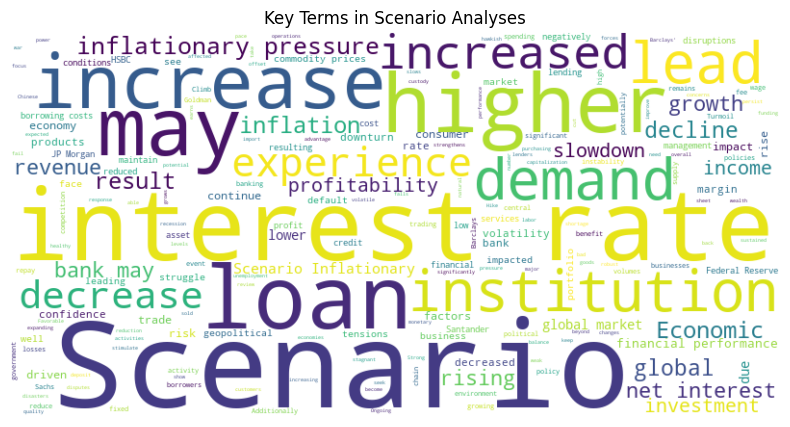

In [52]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all scenario texts into a single string
all_scenarios_text = " ".join(scenarios.values())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_scenarios_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Key Terms in Scenario Analyses")
plt.show()


2. Sentiment Analysis Bar Chart

If each scenario analysis contains sentiment scores (e.g., positive, negative, or neutral), you can create a bar chart to show sentiment distribution across different reports.

For demonstration, let’s assume that each report has a sentiment score on a scale from -1 (negative) to +1 (positive).

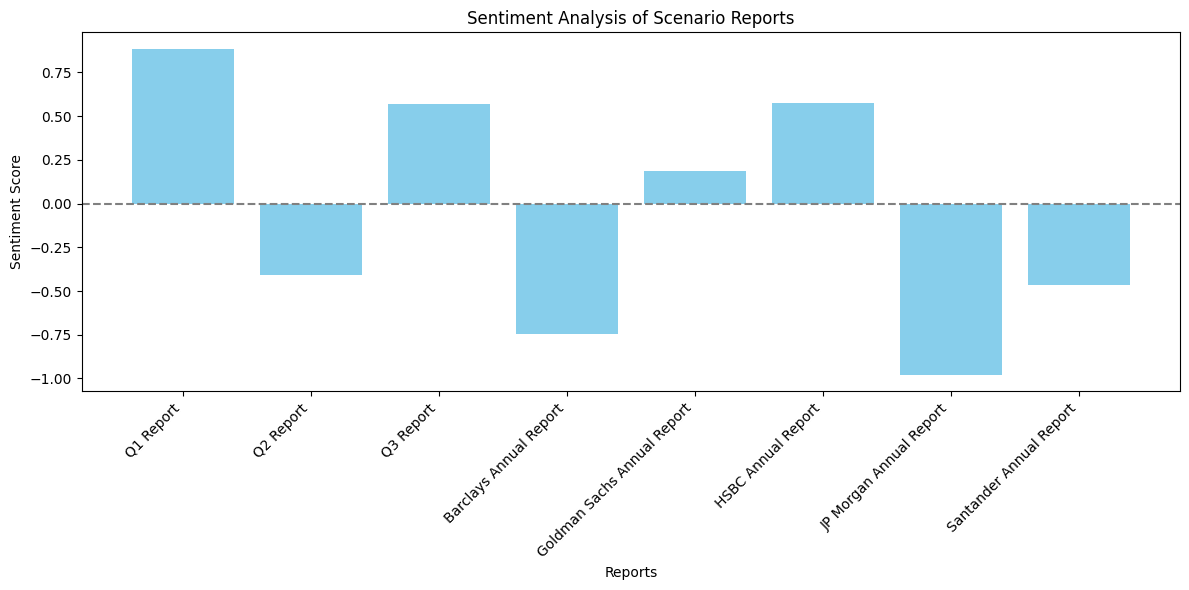

In [53]:
import numpy as np

# Sample sentiment scores for each report (replace these with actual scores if available)
report_names = list(scenarios.keys())
sentiment_scores = np.random.uniform(-1, 1, len(report_names))  # Replace with actual sentiment scores if calculated

# Plot sentiment scores
plt.figure(figsize=(12, 6))
plt.bar(report_names, sentiment_scores, color='skyblue')
plt.axhline(0, color='grey', linestyle='--')  # Zero line for neutral sentiment
plt.xlabel("Reports")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Analysis of Scenario Reports")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


3. Topic Frequency Bar Chart

If certain topics are frequently mentioned across different reports (e.g., "interest rates," "inflation," "recession"), you can count and plot them to see the emphasis in each report.

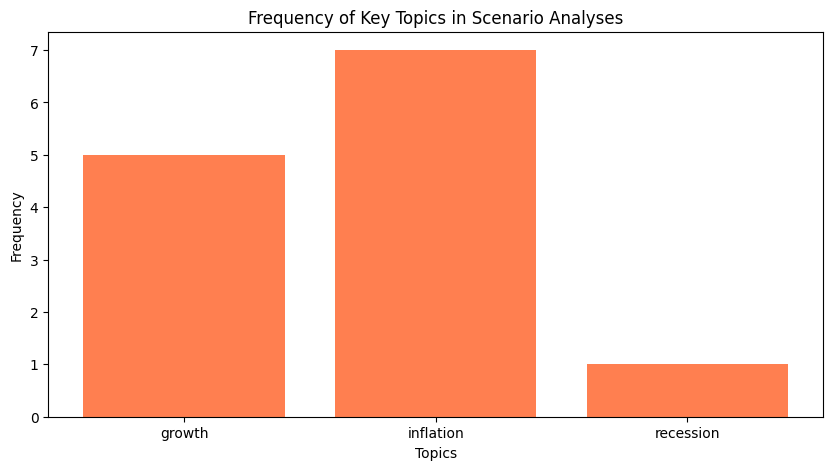

In [54]:
from collections import Counter

# Example topics extracted from scenario text (replace with actual topics if available)
example_topics = ["inflation", "interest rates", "growth", "recession", "market volatility"]
topic_counts = Counter(word for text in scenarios.values() for word in text.split() if word in example_topics)

# Plot topic frequency
plt.figure(figsize=(10, 5))
plt.bar(topic_counts.keys(), topic_counts.values(), color='coral')
plt.xlabel("Topics")
plt.ylabel("Frequency")
plt.title("Frequency of Key Topics in Scenario Analyses")
plt.show()


4. Time Series Analysis of Hypothetical Metrics (if available)

If you have a hypothetical time component (e.g., quarterly data within scenarios), you can plot a trend line over time for a specific metric, such as “projected inflation” or “expected growth rate.” Here’s a general example:

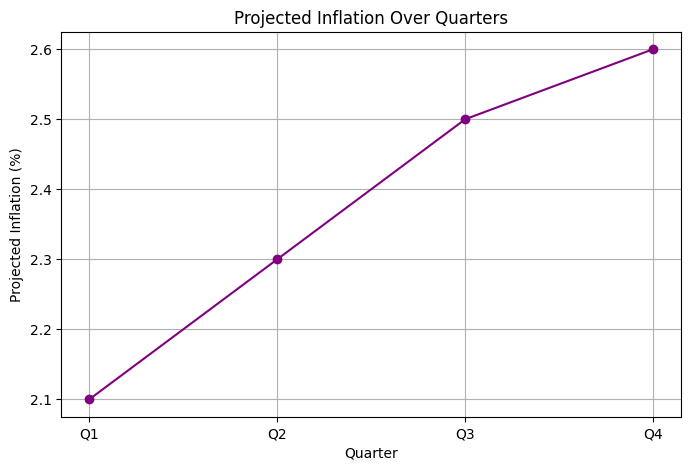

In [55]:
 # Sample quarterly data for a hypothetical metric (replace with actual data if available)
quarters = ['Q1', 'Q2', 'Q3', 'Q4']
projected_inflation = [2.1, 2.3, 2.5, 2.6]  # Replace with actual values

# Plot time series
plt.figure(figsize=(8, 5))
plt.plot(quarters, projected_inflation, marker='o', linestyle='-', color='purple')
plt.xlabel("Quarter")
plt.ylabel("Projected Inflation (%)")
plt.title("Projected Inflation Over Quarters")
plt.grid(True)
plt.show()
